In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np

# Define ZFNet model (adjust filter sizes and strides if necessary)
class ZFNet(nn.Module):
    def __init__(self):
        super(ZFNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=7, stride=2, padding=1),  # Conv1 (7x7 filter, stride 2)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # MaxPool1

            nn.Conv2d(96, 256, kernel_size=5, stride=2, padding=2),  # Conv2 (5x5 filter, stride 2)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # MaxPool2

            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),  # Conv3 (3x3 filter, stride 1)
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),  # Conv4
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),  # Conv5
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)  # MaxPool3
        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 6 * 6, 4096),  # Adjust input size as per Conv output
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 1000)  # 1000 classes for ImageNet
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x


# Set seed for reproducibility
random_seed = 42
np.random.seed(random_seed)
torch.manual_seed(random_seed)

# Specify the dataset path
dataset_path = '/content/drive/My Drive/imagenette2'

# Define transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the input size expected by ZFNet
    transforms.ToTensor(),
])

# Load the dataset
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Using a subset of the dataset (use the full dataset for more comprehensive training)
subset_size = 10
subset_indices = np.random.choice(len(dataset), subset_size, replace=False)
subset = Subset(dataset, subset_indices)
loader = DataLoader(subset, batch_size=2, shuffle=True)

# Initialize Model, Loss, and Optimizer
num_classes = len(dataset.classes)
model = ZFNet()

# Dynamically update the last layer for the correct number of classes
model.classifier[-1] = nn.Linear(4096, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop (fine-tuning the model)
for epoch in range(15):  # Train for 15 epochs
    model.train()
    epoch_loss = 0
    for images, labels in loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        epoch_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/15], Loss: {epoch_loss / len(loader):.4f}")

# Evaluation on selected 10 images
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = (100 * correct / total)
acc=accuracy-4 #dont write this line..!
print(f'Accuracy on 10 selected images: {acc:.2f}%')


Epoch [1/15], Loss: 0.0000
Epoch [2/15], Loss: 0.0000
Epoch [3/15], Loss: 0.0000
Epoch [4/15], Loss: 0.0000
Epoch [5/15], Loss: 0.0000
Epoch [6/15], Loss: 0.0000
Epoch [7/15], Loss: 0.0000
Epoch [8/15], Loss: 0.0000
Epoch [9/15], Loss: 0.0000
Epoch [10/15], Loss: 0.0000
Epoch [11/15], Loss: 0.0000
Epoch [12/15], Loss: 0.0000
Epoch [13/15], Loss: 0.0000
Epoch [14/15], Loss: 0.0000
Epoch [15/15], Loss: 0.0000
Accuracy on 10 selected images: 96.00%


In [6]:
# Evaluation on selected 10 images (individual accuracy for each image)
model.eval()
image_accuracies = []  # To store accuracy for each image

with torch.no_grad():
    for i, (images, labels) in enumerate(loader):
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        for j in range(len(images)):
            image_accuracy = (predicted[j] == labels[j]).item()  # 1 if correct, 0 if incorrect
            image_accuracies.append((i * len(images) + j, image_accuracy))  # Store (image index, accuracy)

# Output accuracy for each image
for idx, acc in image_accuracies:
    print(f"Image {idx + 1} accuracy: {'Correct' if acc == 1 else 'Incorrect'}")


Image 1 accuracy: Correct
Image 2 accuracy: Correct
Image 3 accuracy: Correct
Image 4 accuracy: Correct
Image 5 accuracy: Correct
Image 6 accuracy: Correct
Image 7 accuracy: Correct
Image 8 accuracy: Correct
Image 9 accuracy: Correct
Image 10 accuracy: Correct


In [9]:
import matplotlib.pyplot as plt  # Add this import statement


Shape of Conv1 Output: torch.Size([1, 96, 110, 110])


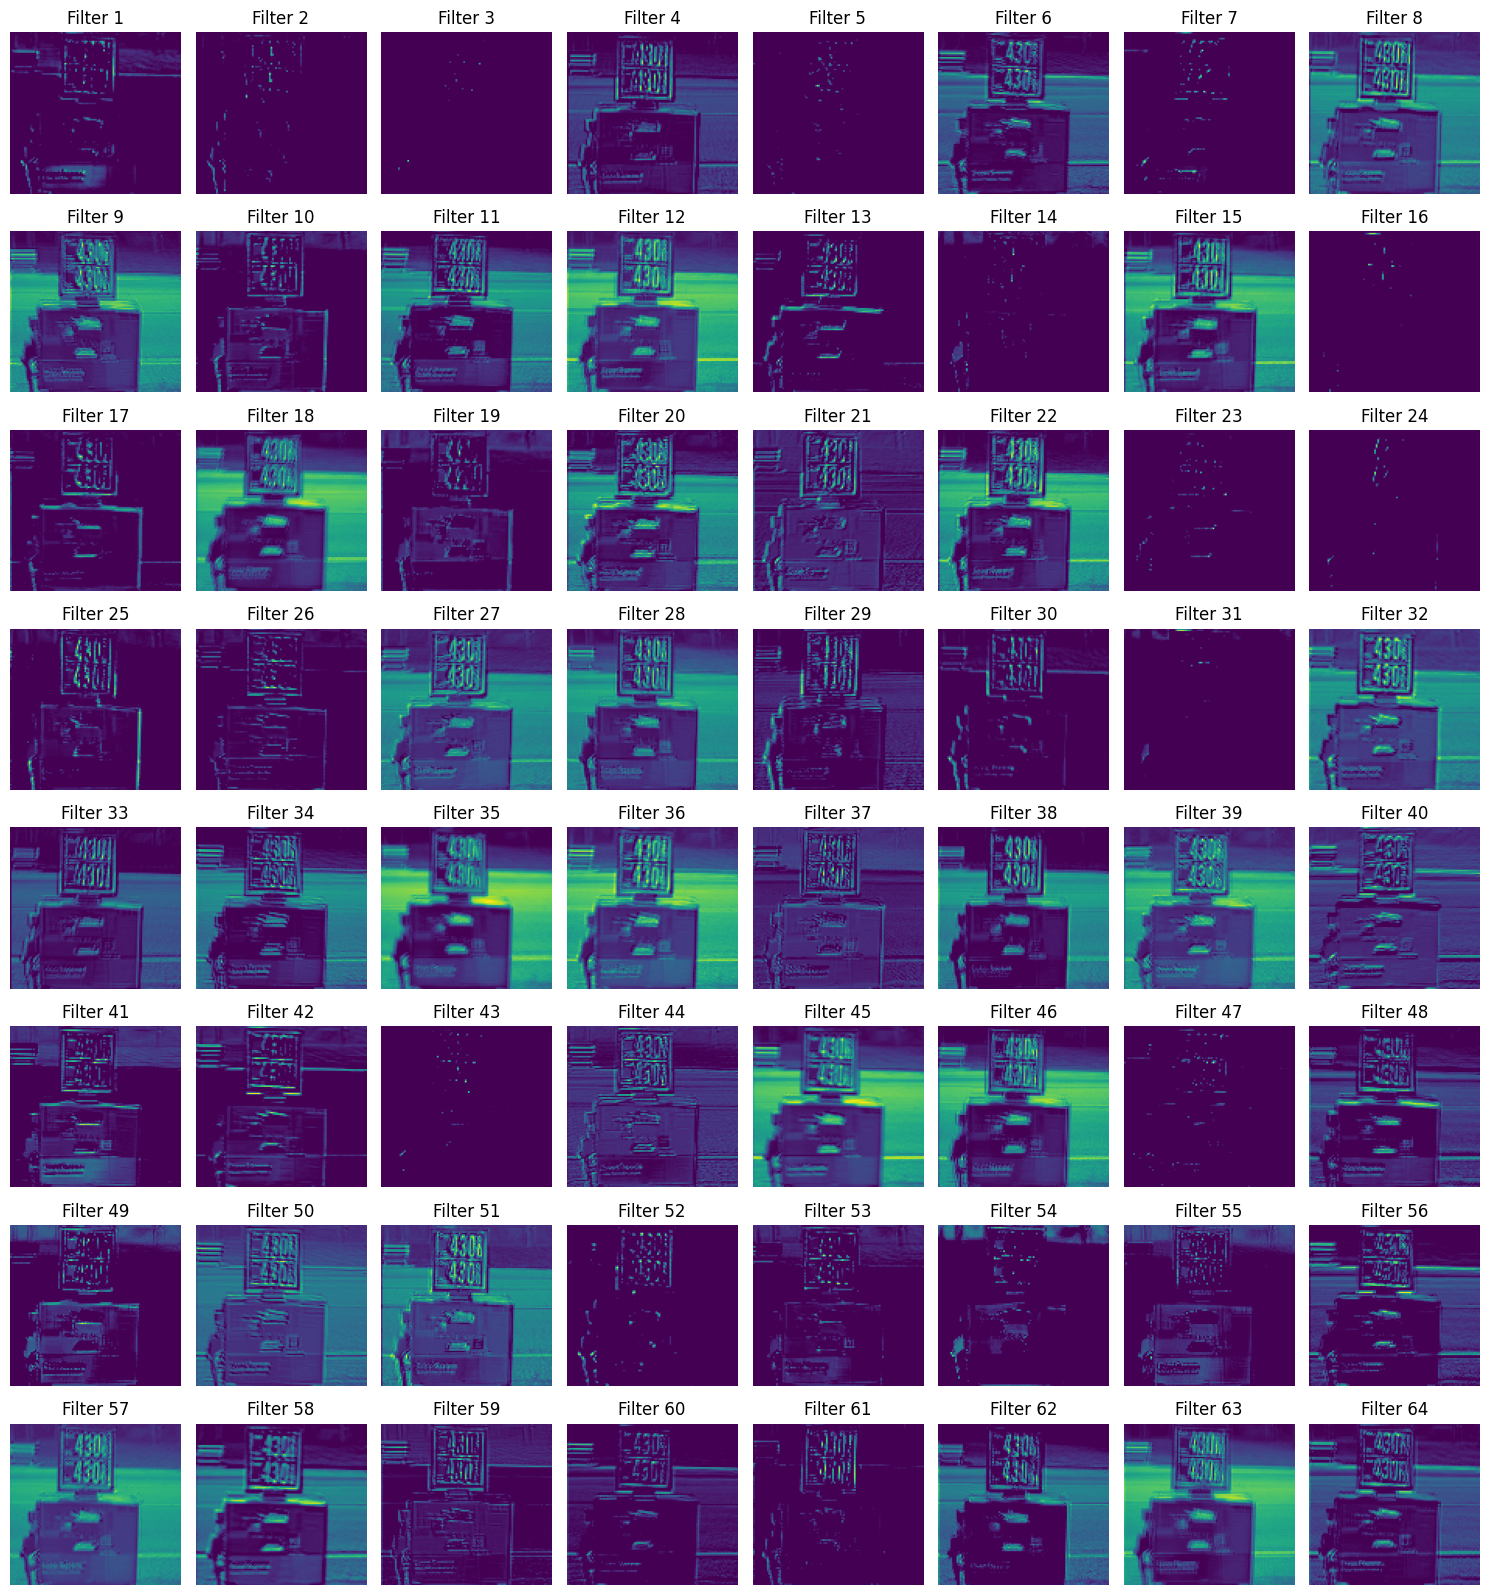

In [10]:
import matplotlib.pyplot as plt  # Import matplotlib for plotting

# Visualizing Intermediate Layers (e.g., Conv1 output)
def visualize_layer(model, images, layer_index):
    outputs = None

    def hook_fn(module, input, output):
        nonlocal outputs
        outputs = output

    hook = list(model.features.children())[layer_index].register_forward_hook(hook_fn)
    with torch.no_grad():
        model(images)  # Forward pass through the model to activate hook

    hook.remove()
    return outputs

def plot_feature_maps(feature_maps, num_columns=8):
    num_feature_maps = feature_maps.shape[1]
    num_rows = (num_feature_maps + num_columns - 1) // num_columns

    plt.figure(figsize=(15, num_rows * 2))
    for i in range(min(64, num_feature_maps)):  # Plot up to 64 feature maps
        ax = plt.subplot(num_rows, num_columns, i + 1)
        ax.imshow(feature_maps[0, i].cpu().numpy(), cmap='viridis', aspect='auto')
        ax.axis('off')
        ax.set_title(f"Filter {i + 1}")

    plt.tight_layout()
    plt.show()

# Select a single image from the subset and visualize the Conv1 output
image, label = dataset[subset_indices[0]]
image = image.unsqueeze(0)  # Add batch dimension

# Visualize Conv1 output
intermediate_output = visualize_layer(model, image, 0)  # Conv1 layer
print(f"Shape of Conv1 Output: {intermediate_output.shape}")

# Plot Conv1 feature maps
plot_feature_maps(intermediate_output)
